各種ライブラリのインポート

In [ ]:
!pip install numpy==1.25.0 #NumPyが最新だと1.26.1だが、他の関連するライブラリの対応範囲を超えており、互換性の問題を回避するため、いったん今回はあえてダウングレードする。また、runtimeのrestartが必要になる。

In [ ]:
!pip install lingam
!pip install factor_analyzer
!pip install igraph
!pip install pygam
!pip install causal-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 6.3 MB/s eta 0:00:00
  Created wheel for semopy: filename=semopy-2.3.11-py3-none-any.whl size=1659681 sha256=3233dd798f3207309af9cbe6d6e06f3a626778b51b72b9a76f005ab16fb15df0
  Stored in directory: /root/.cache/pip/wheels/53/ec/0d/0b294c02d8c4e9e80afea58839f2c1b4706770594bc99ec045
Successfully built semopy
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import sys

import numpy as np
import pandas as pd
import sklearn
import warnings
import os
import csv
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import graphviz
import lingam
from lingam.utils import print_causal_directions, print_dagc, make_dot
from lingam.utils import predict_adaptive_lasso
from lingam.bootstrap import BootstrapResult, BootstrapMixin

import numbers
from sklearn.utils import check_array, resample
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LassoLarsIC
from lingam.utils import print_causal_directions, print_dagc, make_dot, make_prior_knowledge

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

In [ ]:
# numpyでの小数点以下桁数表示と指数表記の禁止を設定する
np.set_printoptions(precision=3, suppress=True)

# FutureWarning については非表示とする
warnings.simplefilter('ignore', FutureWarning)

# 積の構造的因果モデルとする
take_log = True
log_cutoff_for_zeros = -5



```
# これはコードとして書式設定されます
```

LiNGAMの基礎設定

In [ ]:
np.random.seed(1)
tau_max = 1 # (number of lagged steps)-1
n_sampling = 1000 # bootstrap sampling number

In [ ]:
#データセットを読み込む
X0 = pd.read_csv('/content/241231_3type_lag1.csv', index_col=None)

#重点支援3類型でデータを分ける
X = [None for _ in range(3)]

X_array = [None for _ in range(3)]
for i_type in range(3):
    X[i_type] = X0[X0['support_type']==i_type+1]
    X[i_type] = X[i_type].drop(['FY', 'support_type'], axis=1)
    if take_log:
        X[i_type] = np.log10( np.maximum(X[i_type],10**log_cutoff_for_zeros) )
    X_array[i_type]= X[i_type].values

x_list = X[0].columns.tolist()
n_features = X[0].shape[1]//(tau_max+1)

In [ ]:
x_list

['M_graduate',
 'D_entrance',
 'Ph.D_Graduate',
 'PosDoc',
 'AcaPos',
 'Basic_income',
 'Students_per_teacher',
 'DC1',
 'KAKEN',
 'Papers',
 'M_graduate_L1',
 'D_entrance_L1',
 'Ph.D_graduate_L1',
 'PosDoc_L1',
 'AcaPos_L1',
 'Basic_income_L1',
 'Students_per_teacher_L1',
 'DC1_L1',
 'KAKEN_L1',
 'Papers_L1']

In [ ]:
# 重点支援1
X[0]

,M_graduate,D_entrance,Ph.D_Graduate,PosDoc,AcaPos,Basic_income,Students_per_teacher,DC1,KAKEN,Papers,M_graduate_L1,D_entrance_L1,Ph.D_graduate_L1,PosDoc_L1,AcaPos_L1,Basic_income_L1,Students_per_teacher_L1,DC1_L1,KAKEN_L1,Papers_L1
1,2.096910,0.602060,-5.000000,-5.000000,-5.000000,6.789847,1.176091,-5.00000,5.142515,1.919078,2.025306,0.477121,-5.000000,-5.000000,-5.000000,6.779954,1.158362,-5.0,5.145153,1.995635
2,2.444045,0.698970,1.278754,0.301030,0.602060,6.411047,1.252853,-5.00000,5.098471,2.404834,2.332438,0.778151,1.079181,0.477121,0.301030,6.414452,1.230449,-5.0,5.149773,2.471292
3,1.079181,0.301030,0.477121,0.301030,-5.000000,6.090853,1.278754,-5.00000,4.711639,1.397940,1.041393,0.301030,0.000000,-5.000000,-5.000000,6.094054,1.264818,-5.0,4.812044,1.544068
4,1.986772,1.113943,1.079181,-5.000000,-5.000000,6.378898,1.025306,-5.00000,5.085683,2.294466,1.913814,1.146128,1.000000,0.698970,-5.000000,6.357790,1.008600,-5.0,5.126781,2.322219
5,2.068186,0.301030,1.000000,0.000000,0.477121,6.327193,1.167317,-5.00000,5.177277,2.426511,2.096910,0.301030,1.146128,-5.000000,-5.000000,6.357311,1.143015,-5.0,5.165096,2.336460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
854,2.875640,1.698970,2.143015,1.041393,1.278754,7.142538,1.071882,0.90309,6.246197,3.329601,2.865104,1.755875,2.167317,1.230449,1.230449,7.140536,1.071882,0.0,6.246139,3.279667
855,2.496930,0.301030,1.505150,-5.000000,0.477121,6.942965,0.939519,-5.00000,5.678609,2.793092,2.487138,0.845098,1.301030,-5.000000,0.698970,6.948042,0.929419,-5.0,5.648857,2.818226
856,2.557507,1.113943,1.732394,-5.000000,1.113943,6.967220,0.869232,0.30103,5.801918,2.912753,2.530200,1.322219,1.770852,0.000000,1.079181,6.962534,0.886491,-5.0,5.758776,2.885361
857,2.763428,1.176091,2.033424,1.079181,1.397940,7.184700,0.963788,0.30103,5.980231,3.143639,2.767156,1.431364,1.934498,0.602060,1.079181,7.177978,0.968483,-5.0,5.996980,3.089198


In [ ]:
X_array[0]

array([[ 2.097,  0.602, -5.   , ..., -5.   ,  5.145,  1.996],
       [ 2.444,  0.699,  1.279, ..., -5.   ,  5.15 ,  2.471],
       [ 1.079,  0.301,  0.477, ..., -5.   ,  4.812,  1.544],
       ...,
       [ 2.558,  1.114,  1.732, ..., -5.   ,  5.759,  2.885],
       [ 2.763,  1.176,  2.033, ..., -5.   ,  5.997,  3.089],
       [ 2.52 ,  1.362,  1.756, ...,  0.   ,  5.773,  2.921]])

In [ ]:
#重点支援2
X[1]

,M_graduate,D_entrance,Ph.D_Graduate,PosDoc,AcaPos,Basic_income,Students_per_teacher,DC1,KAKEN,Papers,M_graduate_L1,D_entrance_L1,Ph.D_graduate_L1,PosDoc_L1,AcaPos_L1,Basic_income_L1,Students_per_teacher_L1,DC1_L1,KAKEN_L1,Papers_L1
16,0.778151,-5.000000,-5.000000,-5.000000,-5.000000,6.360874,0.518514,-5.00000,4.930185,1.518514,0.602060,-5.000000,-5.000000,-5.000000,-5.000000,6.353734,0.531479,-5.000000,4.970068,1.579784
22,2.459392,1.414973,2.376577,0.845098,1.041393,7.136003,0.579784,0.30103,6.274760,3.165244,2.465383,1.462398,2.383815,1.230449,1.041393,7.149639,0.579784,0.301030,6.280344,3.174351
23,2.071882,1.431364,1.278754,0.698970,0.301030,6.469699,1.243038,0.00000,5.582586,1.491362,2.107210,1.518514,1.568202,0.778151,0.000000,6.447989,1.250420,0.000000,5.513098,1.414973
24,2.600973,1.690196,1.724276,1.397940,0.477121,6.649843,1.143015,0.00000,5.144948,2.243038,2.588832,1.591065,1.681241,1.113943,0.301030,6.636892,1.149219,0.000000,5.173128,2.267172
26,2.359835,1.633468,1.944483,0.477121,1.146128,6.641919,1.139879,-5.00000,5.488325,2.413300,2.429752,1.778151,1.949390,1.785330,1.000000,6.630718,1.139879,0.301030,5.463997,2.487138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
814,2.496930,1.748188,1.770852,1.301030,0.000000,6.726582,0.857332,-5.00000,5.545307,2.883661,2.440909,1.707570,1.785330,1.255273,0.477121,6.730034,0.845098,0.000000,5.480179,2.834421
836,2.212188,0.954243,1.361728,0.778151,0.778151,6.549310,1.110590,-5.00000,5.198520,2.374748,2.283301,1.204120,1.322219,0.602060,0.477121,6.510480,1.117271,-5.000000,5.294356,2.394452
837,2.530200,1.799341,1.913814,1.230449,1.176091,6.719010,0.672098,0.00000,6.027280,2.974051,2.521138,1.792392,1.991226,1.380211,1.079181,6.763116,0.672098,0.477121,6.025474,2.962369
849,2.770115,1.322219,1.880814,0.477121,0.903090,6.697909,1.201397,-5.00000,5.729367,3.029384,2.768638,1.397940,1.857332,1.079181,0.903090,6.739084,1.193125,0.301030,5.782795,3.009876


In [ ]:
X_array[1]

array([[ 0.778, -5.   , -5.   , ..., -5.   ,  4.97 ,  1.58 ],
       [ 2.459,  1.415,  2.377, ...,  0.301,  6.28 ,  3.174],
       [ 2.072,  1.431,  1.279, ...,  0.   ,  5.513,  1.415],
       ...,
       [ 2.53 ,  1.799,  1.914, ...,  0.477,  6.025,  2.962],
       [ 2.77 ,  1.322,  1.881, ...,  0.301,  5.783,  3.01 ],
       [ 1.176,  0.602,  0.778, ..., -5.   ,  4.584,  1.591]])

In [ ]:
#重点支援3
X[2]

,M_graduate,D_entrance,Ph.D_Graduate,PosDoc,AcaPos,Basic_income,Students_per_teacher,DC1,KAKEN,Papers,M_graduate_L1,D_entrance_L1,Ph.D_graduate_L1,PosDoc_L1,AcaPos_L1,Basic_income_L1,Students_per_teacher_L1,DC1_L1,KAKEN_L1,Papers_L1
0,3.250664,2.421604,2.684845,1.968483,1.770852,7.525837,0.875061,1.431364,6.837729,3.691789,3.264346,2.403121,2.746634,1.875061,1.724276,7.528657,0.863323,1.623249,6.809267,3.688953
9,3.308991,2.555094,2.817565,2.021189,1.908485,7.629442,0.778151,1.653213,7.042317,3.906658,3.301464,2.507856,2.800029,2.071882,1.934498,7.622948,0.755875,1.707570,7.020475,3.891482
15,3.260310,2.372912,2.603144,2.008600,1.690196,7.556772,0.959041,1.477121,6.582060,3.566084,3.268578,2.385606,2.570543,2.021189,1.531479,7.552465,0.954243,1.491362,6.599040,3.575419
20,3.063333,2.049218,2.439333,1.505150,1.672098,7.210687,1.082785,0.477121,6.343753,3.381296,3.058805,2.004321,2.445604,1.361728,1.505150,7.197216,1.082785,1.000000,6.374706,3.397245
21,3.500099,2.899273,3.221153,1.929419,2.146128,7.879628,0.857332,2.305351,7.356688,4.122216,3.490661,2.937016,3.213252,2.021189,2.089905,7.868754,0.857332,2.334454,7.365172,4.130334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
831,3.344785,2.506505,2.874482,2.071882,1.892095,7.652195,0.832509,1.681241,7.014223,3.961611,3.369587,2.550228,2.872739,2.029384,1.826075,7.642504,0.838849,1.672098,7.004246,3.948560
833,3.107888,2.064458,2.480007,1.176091,1.602060,7.305734,1.012837,1.000000,6.515240,3.539578,3.118265,2.060698,2.498311,1.204120,1.716003,7.310419,1.008600,0.845098,6.475596,3.511482
841,2.940516,1.681241,2.365488,1.301030,1.380211,7.257619,0.959041,0.301030,6.430123,3.412964,2.985426,1.819544,2.418301,1.518514,1.477121,7.270115,0.949390,0.301030,6.464288,3.417638
842,3.155640,2.235528,2.584331,1.079181,1.968483,7.397122,0.897627,0.954243,6.462560,3.604010,3.138934,2.143015,2.593286,1.740363,1.913814,7.402758,0.913814,0.602060,6.474480,3.600755


In [ ]:
X_array[2]

array([[3.251, 2.422, 2.685, ..., 1.623, 6.809, 3.689],
       [3.309, 2.555, 2.818, ..., 1.708, 7.02 , 3.891],
       [3.26 , 2.373, 2.603, ..., 1.491, 6.599, 3.575],
       ...,
       [2.941, 1.681, 2.365, ..., 0.301, 6.464, 3.418],
       [3.156, 2.236, 2.584, ..., 0.602, 6.474, 3.601],
       [3.297, 2.378, 2.757, ..., 1.544, 6.842, 3.802]])

事前知識の準備

In [ ]:
def make_prior_knowledge_graph(prior_knowledge_matrix):
    d = graphviz.Digraph(engine='dot')

    labels = [f'x{i}' for i in range(prior_knowledge_matrix.shape[0])]
    for label in labels:
        d.node(label, label)

    dirs = np.where(prior_knowledge_matrix > 0)
    for to, from_ in zip(dirs[0], dirs[1]):
        d.edge(labels[from_], labels[to])

    dirs = np.where(prior_knowledge_matrix < 0)
    for to, from_ in zip(dirs[0], dirs[1]):
        if to != from_:
            d.edge(labels[from_], labels[to], style='dashed')
    return d

In [ ]:
prior_knowledge = np.loadtxt('/content/250106_prior_knowledge_lag1.csv', delimiter=',',dtype ='int64')
prior_knowledge

array([[-1,  0, -1, -1, -1, -1, -1, -1, -1, -1,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [-1, -1, -1,  0,  0, -1, -1, -1, -1, -1,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [-1, -1, -1, -1, -1, -1

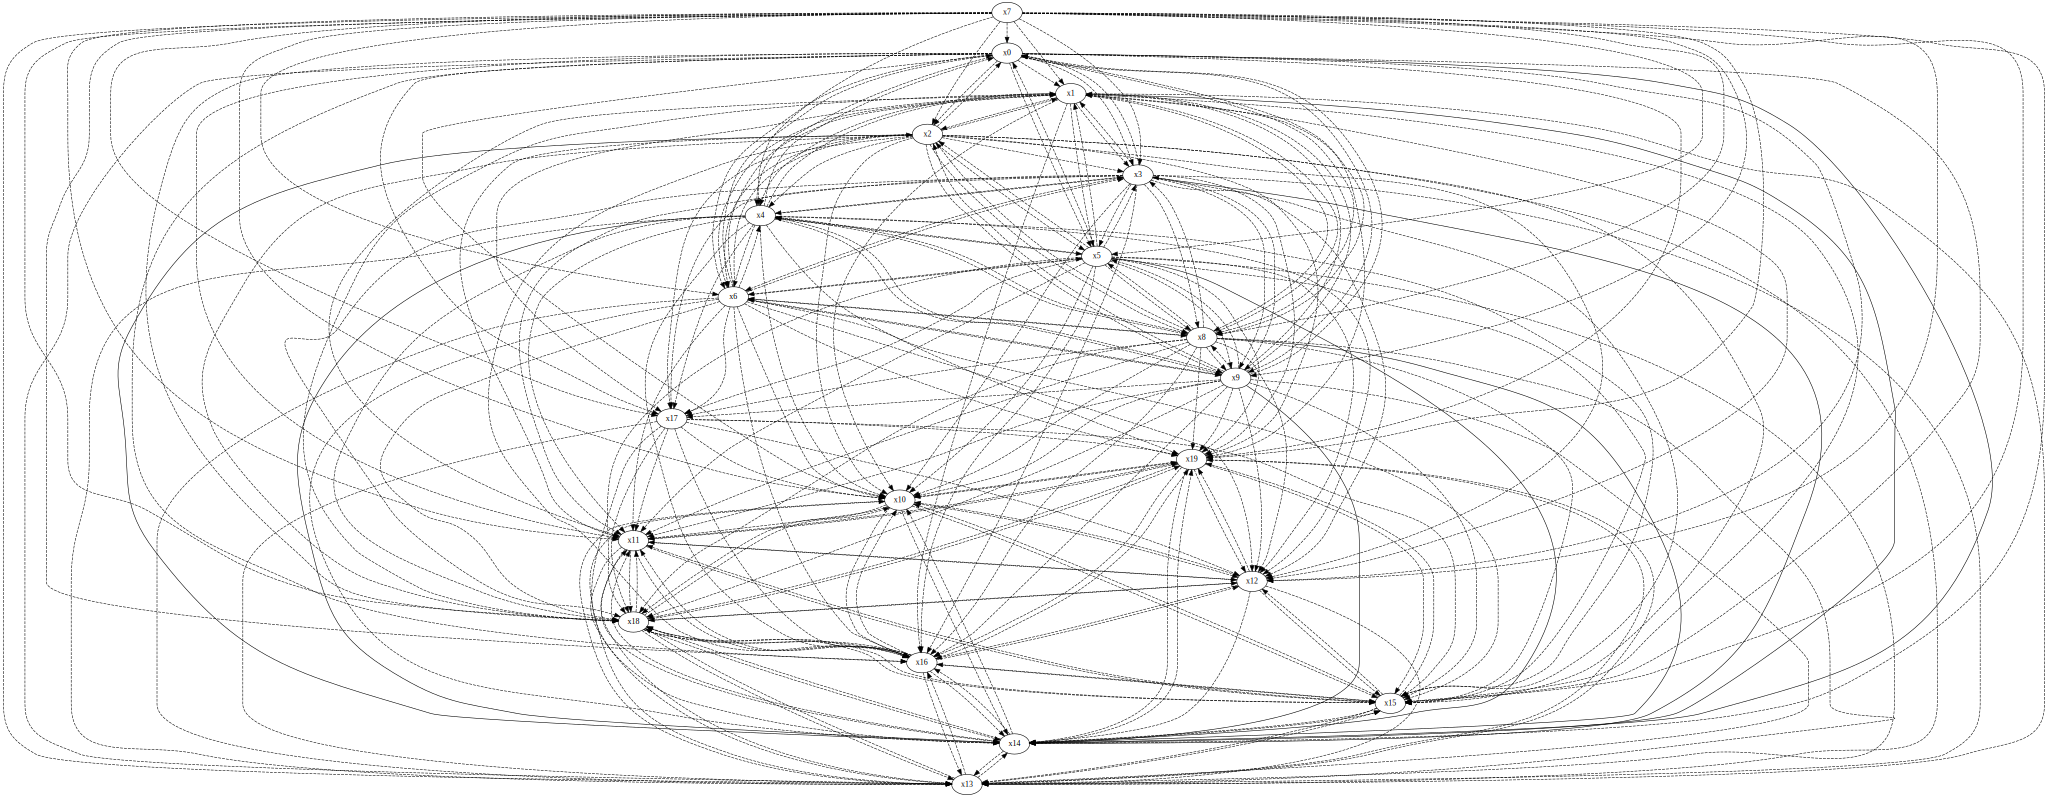

In [ ]:
make_prior_knowledge_graph(prior_knowledge)

LiNGAMの実行

In [ ]:
#データセット全体
for i_type in range(3):
        model = lingam.DirectLiNGAM(X[i_type],prior_knowledge=prior_knowledge)
        result = model.fit(X[i_type])
        result_concatenated = model._adjacency_matrix
        result_concatenated[0:n_features,:] = 0.0
        dot1 = make_dot(model._adjacency_matrix, labels=x_list)
        dot1.format = 'pdf'
        dot1.render('./longitudinal_support_group_' + str(i_type+1), view=False)

In [ ]:
for i_type in range(3):
        model = lingam.DirectLiNGAM(X[i_type],prior_knowledge=prior_knowledge)
        bs_results = model.bootstrap(X[i_type],n_sampling)
        causal_effects = bs_results.get_total_causal_effects(min_causal_effect=0.01)
        print(bs_results.adjacency_matrices_.shape[0])

        figure_title = 'Doctor_LLiNGAM_histogram_support_group_' + str(i_type+1) + '.pdf'
        pdf_figs = PdfPages(figure_title)

        for f1 in range (10):
            fig = plt.figure(figsize=(6,4.5))
            fig.subplots_adjust(wspace=0.7, hspace=0.75)
            for i in range (10):
                t_from = 0
                t_to = 1
                to_index = i + t_to*n_features
                from_index = f1 + t_from*n_features
                title = 'x' + str(f1) + '(' + str(t_from) + ') → ' + 'x' + str(i) + '(' + str(t_to) + ')'
                x_d = bs_results.adjacency_matrices_[:, to_index, from_index]
                ax1 = fig.add_subplot(3,4,i+1)
                ax1.hist(x_d, bins=40)

                plt.tick_params(axis='x', labelsize=6)
                plt.tick_params(axis='y', labelsize=6)

                ax1.set_xlabel('Amplitude', fontsize = 8)
                ax1.set_ylabel('freq', fontsize = 8)
                ax1.set_title(title, fontsize = 9)
                """
                if i==0 :
                   ax1.legend(loc='upper left')
                """
            pdf_figs.savefig()
            plt.close()

        for f1 in range (10):
            fig = plt.figure(figsize=(6,4.5))
            fig.subplots_adjust(wspace=0.7, hspace=0.75)
            for i in range (10):
                t_from = 1
                t_to = 1
                to_index = i + t_to*n_features
                from_index = f1 + t_from*n_features
                title = 'x' + str(f1) + '(' + str(t_from) + ') → ' + 'x' + str(i) + '(' + str(t_to) + ')'
                x_d = bs_results.adjacency_matrices_[:, to_index, from_index]
                ax1 = fig.add_subplot(3,4,i+1)
                ax1.hist(x_d, bins=40)

                plt.tick_params(axis='x', labelsize=6)
                plt.tick_params(axis='y', labelsize=6)

                ax1.set_xlabel('Amplitude', fontsize = 8)
                ax1.set_ylabel('freq', fontsize = 8)
                ax1.set_title(title, fontsize = 9)
                """
                if i==0 :
                   ax1.legend(loc='upper left')
                """
            pdf_figs.savefig()
            plt.close()
        pdf_figs.close()

1000
1000
1000
